# Projet M1 ISI: Apprentissage auto-supervisé de représentations audio pour l'exploration de paysages sonores

In [5]:
%cd /content
# On télécharge le bibliothèque WavTokenizer (on clone le repo git)
!git clone https://github.com/jishengpeng/WavTokenizer.git
%cd WavTokenizer

# On importe le constructeur et le convertisseur audio (WavTokenizer prend des fichiers audios de Fs=24kHz)
from decoder.pretrained import WavTokenizer
from encoder.utils import convert_audio

%cd /content

/content
fatal: destination path 'WavTokenizer' already exists and is not an empty directory.
/content/WavTokenizer
/content


In [ ]:
# On télécharge le modèle de WavTokenizer que nous allons utiliser
!wget https://huggingface.co/novateur/WavTokenizer-large-speech-75token/resolve/main/wavtokenizer_large_speech_320_v2.ckpt -O /content/WavTokenizer/large_speech_model.ckpt
!wget https://huggingface.co/novateur/WavTokenizer-medium-music-audio-75token/resolve/main/wavtokenizer_medium_music_audio_320_24k_v2.ckpt -O /content/WavTokenizer/medium_music_audio_model.ckpt
!wget https://huggingface.co/novateur/WavTokenizer-large-unify-40token/resolve/main/wavtokenizer_large_unify_600_24k.ckpt -O /content/WavTokenizer/large_unify_model.ckpt
# Possibilité de telecharger un autre modele => cf. wavtokenizer_large_unify_600_24k? (config 40tok/s)

--2025-06-23 14:13:08--  https://huggingface.co/novateur/WavTokenizer-large-speech-75token/resolve/main/wavtokenizer_large_speech_320_v2.ckpt
Resolving huggingface.co (huggingface.co)... 18.160.143.32, 18.160.143.76, 18.160.143.99, ...
Connecting to huggingface.co (huggingface.co)|18.160.143.32|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/83/44/83442801d7c06ef2d684a7739c4037681c8f03b9349342d3cbe9e0ae7c0b93a6/5dd430d5f0d96e2313babb1b896d0f990b65bfd143b2894fc3851cfc3cca9846?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27wavtokenizer_large_speech_320_v2.ckpt%3B+filename%3D%22wavtokenizer_large_speech_320_v2.ckpt%22%3B&Expires=1750691588&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MDY5MTU4OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzgzLzQ0LzgzNDQyODAxZDdjMDZlZjJkNjg0YTc3MzljNDAzNzY4MWM4ZjAzYjkzNDkzNDJkM2NiZTllMGFlN2MwYjkzYTYvNWRkNDMwZDVmMGQ5N

In [6]:
# On télécharge le dossier comprésé contenant les tokens calculés au préalable
%cd /content/
import os
zip_path_large_speech = "/content/esc50_tokens_WavTokenizer_large_speech.zip"
zip_path_medium_music_audio = "/content/esc50_tokens_WavTokenizer_medium_music_audio.zip"
zip_path_large_unify = "/content/esc50_tokens_WavTokenizer_large_unify.zip"

# Extraction des tokens (si téléchargés)
if not os.path.exists(zip_path_large_speech):
    !wget https://raw.githubusercontent.com/GhilesREDJDAL/Projet-M1-ISI-SSL-paysages-sonores/main/esc50_tokens_WavTokenizer_large_speech.zip -O {zip_path_large_speech}
    !unzip {zip_path_large_speech} -d /content/

if not os.path.exists(zip_path_medium_music_audio):
    !wget https://raw.githubusercontent.com/GhilesREDJDAL/Projet-M1-ISI-SSL-paysages-sonores/main/esc50_tokens_WavTokenizer_medium_music_audio.zip -O {zip_path_medium_music_audio}
    !unzip {zip_path_medium_music_audio} -d /content/

if not os.path.exists(zip_path_large_unify):
    !wget https://raw.githubusercontent.com/GhilesREDJDAL/Projet-M1-ISI-SSL-paysages-sonores/main/esc50_tokens_WavTokenizer_large_unify.zip -O {zip_path_large_unify}
    !unzip {zip_path_large_unify} -d /content/

/content


In [7]:
# Import des bibliothèques utilisées
import torch
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tqdm import tqdm # Pour la barre de progression (inference et parcours des fichiers)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN

In [8]:
# On télécharge le dataset sur lequel nous effectuons nos tests
# Autres datasets à tester: FSC-22, EFSC-24 (plus orientés fôrets, à trouver)
%cd /content
!git clone https://github.com/karolpiczak/ESC-50.git
%cd ESC-50
%cd /content/
audio_dir = "/content/ESC-50/audio"
meta_csv = "/content/ESC-50/meta/esc50.csv"

metadata = pd.read_csv(meta_csv)

/content
fatal: destination path 'ESC-50' already exists and is not an empty directory.
/content/ESC-50
/content


In [9]:
# Détermine le périphérique à utiliser (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chemin vers le fichier de configuration du modèle WavTokenizer
config_path_75 = "/content/WavTokenizer/configs/wavtokenizer_smalldata_frame75_3s_nq1_code4096_dim512_kmeans200_attn.yaml"
config_path_40 = "/content/WavTokenizer/configs/wavtokenizer_smalldata_frame40_3s_nq1_code4096_dim512_kmeans200_attn.yaml"
# Chemin vers le fichier du modèle pré-entraîné WavTokenizer
speech_model_path = "/content/WavTokenizer/large_speech_model.ckpt" #75
medium_music_audio_model_path = "/content/WavTokenizer/medium_music_audio_model.ckpt" #75
large_unify_model_path = "/content/WavTokenizer/large_unify_model.ckpt" #40

# Charge le modèle WavTokenizer:
wavtokenizer_large_speech = WavTokenizer.from_pretrained0802(config_path_75, speech_model_path)
wavtokenizer_medium_music_audio = WavTokenizer.from_pretrained0802(config_path_75, medium_music_audio_model_path)
wavtokenizer_large_unify = WavTokenizer.from_pretrained0802(config_path_40, large_unify_model_path)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [ ]:
"""
# Inference: pas besoin de refaire, les tokens sont fournit dans le fichier .zip

# Répertoire de sortie pour les tokens
large_speech_output_dir_tok = "/content/esc50_tokens_WavTokenizer_large_speech"
medium_music_audio_output_dir_tok = "/content/esc50_tokens_WavTokenizer_medium_music_audio"
large_unify_output_dir_tok = "/content/esc50_tokens_WavTokenizer_large_unify"
# Répertoire de sortie pour les features (commenté, car non utilisé)
#output_dir_features = "/content/esc50_features_WavTokenizer"

# Crée les répertoires de sortie s'ils n'existent pas déjà
# os.makedirs(output_dir_features, exist_ok=True) # Commenté car output_dir_features n'est pas utilisé
os.makedirs(large_speech_output_dir_tok, exist_ok=True)
os.makedirs(medium_music_audio_output_dir_tok, exist_ok=True)
os.makedirs(large_unify_output_dir_tok, exist_ok=True)

# Déplace le modèle WavTokenizer sur le périphérique sélectionné (GPU ou CPU)
wavtokenizer_large_speech = wavtokenizer_large_speech.to(device)
wavtokenizer_medium_music_audio = wavtokenizer_medium_music_audio.to(device)
wavtokenizer_large_unify = wavtokenizer_large_unify.to(device)

# On boucle sur chaque fichier audio dans le répertoire d'audio
for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
    # Extrait le nom du fichier audio et construit le chemin complet
    filename = row["filename"]
    path = os.path.join(audio_dir, filename)

    # Traitement du fichier audio
    try:
        # Charge le waveform et le taux d'échantillonnage
        waveform, sr = torchaudio.load(path)
        # Convertit le waveform au format requis par WavTokenizer (24kHz, mono)
        waveform = convert_audio(waveform, sr, 24000, 1).to(device)
        bandwidth_id = torch.tensor([0]).to(device)

        # Encode le waveform pour obtenir les features et les codes discrets
        _, discrete_code_large_speech = wavtokenizer_large_speech.encode_infer(waveform, bandwidth_id=bandwidth_id)
        _, discrete_code_medium_music_audio = wavtokenizer_medium_music_audio.encode_infer(waveform, bandwidth_id=bandwidth_id)
        _, discrete_code_large_unify = wavtokenizer_large_unify.encode_infer(waveform, bandwidth_id=bandwidth_id)

        # Construit les chemins de sortie pour les tokens et les features
        token_path_large_speech = os.path.join(large_speech_output_dir_tok, filename.replace(".wav", ".pt"))
        token_path_medium_music_audio = os.path.join(medium_music_audio_output_dir_tok, filename.replace(".wav", ".pt"))
        token_path_large_unify = os.path.join(large_unify_output_dir_tok, filename.replace(".wav", ".pt"))
        # feature_path = os.path.join(output_dir_features, filename.replace(".wav", ".pt")) # Commenté car non utilisé

        # Sauvegarde les codes discrets (tokens)
        torch.save(discrete_code_large_speech.cpu(), token_path_large_speech)
        torch.save(discrete_code_medium_music_audio.cpu(), token_path_medium_music_audio)
        torch.save(discrete_code_large_unify.cpu(), token_path_large_unify)

        # Sauvegarde les features (commenté, car non utilisé)
        #torch.save(features.cpu(), feature_path) # Pas besoin de sauvegarder les features (utilisation de code_to_features)

    # Gère les exceptions qui peuvent survenir lors du traitement d'un fichier audio
    except Exception as e:
        # Affiche un message d'erreur si un problème survient
        print(f"Error with {filename}: {e}")
"""

100%|██████████| 2000/2000 [03:02<00:00, 10.93it/s]


In [ ]:
"""
%cd /content
!zip -r esc50_tokens_WavTokenizer_large_speech.zip esc50_tokens_WavTokenizer_large_speech
!zip -r esc50_tokens_WavTokenizer_medium_music_audio.zip esc50_tokens_WavTokenizer_medium_music_audio
!zip -r esc50_tokens_WavTokenizer_large_unify.zip esc50_tokens_WavTokenizer_large_unify
"""

WavTokenizer attribue à chaque fichier audio une séquence de tokens (40 ou 75 tokens par secondes), où chaque token représente une ligne dans un codebook, cette ligne correspondant à une représentation audio pré-apprise lors de l'entrainement (feature).
Les features extraites directement par WavTokenizer sont identiques à celles obtenues en utilisant la fonction codes_to_features sur les codes discrets (tokens). C'est pourquoi les features brutes n'ont pas été utilisées ou enregistrées séparément dans ce notebook, car les vecteurs du codebook dérivés des tokens fournissent les mêmes informations pour l'analyse.

In [11]:
# Rrépertoire contenant les tokens enregistrés
tokens_dir_large_speech = '/content/esc50_tokens_WavTokenizer_large_speech'
tokens_dir_medium_music_audio = '/content/esc50_tokens_WavTokenizer_medium_music_audio'
tokens_dir_large_unify = '/content/esc50_tokens_WavTokenizer_large_unify'

# Charge les métadonnées du dataset ESC-50
meta_df = pd.read_csv('/content/ESC-50/meta/esc50.csv')
# Remplace l'extension '.wav' par '.pt' dans la colonne 'filename' pour correspondre aux fichiers de tokens
meta_df['filename'] = meta_df['filename'].str.replace('.wav', '.pt')

# Initialise des listes vides pour stocker différentes informations sur les tokens et features (selon les cas)
file_data_list_ls = []
file_data_list_mma = []
file_data_list_lu = []

tokens_dir_ls = tokens_dir_large_speech
tokens_dir_mma = tokens_dir_medium_music_audio
tokens_dir_lu = tokens_dir_large_unify

wavtokenizer_ls = wavtokenizer_large_speech
wavtokenizer_mma = wavtokenizer_medium_music_audio
wavtokenizer_lu = wavtokenizer_large_unify

# On recupère la liste des nom de fichiers
filenames_list = [f for f in os.listdir(tokens_dir_ls) if f.endswith('.pt')] # Ignore les fichiers qui ne se terminent pas par '.pt'
filenames_list.sort() # Sort car os.listdir ne founit pas une liste de fichier constante, elle peut varier dans le temps

# Boucle sur chaque fichier dans le répertoire des tokens
for fname in tqdm(filenames_list):
    # Construit le chemin complet du fichier de tokens
    tok_path_ls = os.path.join(tokens_dir_ls, fname)
    tok_path_mma = os.path.join(tokens_dir_mma, fname)
    tok_path_lu = os.path.join(tokens_dir_lu, fname)
    # Charge les tokens à partir du fichier
    tokens_ls = torch.load(tok_path_ls)
    tokens_mma = torch.load(tok_path_mma)
    tokens_lu = torch.load(tok_path_lu)
    #print(np.shape(tokens))

    # Filtrage du "silence"
    # Les sons étant isolés, le silence semble bien correspondre aux valeurs de tokens apparaissant le plus souvent sur l'ensemble des fichiers. Selon les modèles on a les tokens (470, 1771, et [2548+943])
    filtered_tokens_ls = tokens_ls[tokens_ls != 470].unsqueeze(0).unsqueeze(0)
    filtered_tokens_mma = tokens_mma[tokens_mma != 1771].unsqueeze(0).unsqueeze(0)
    # Deux tokens de silence pour le modèle a 40tk/s
    filtered_tokens_lu = tokens_lu[tokens_lu != 2548].unsqueeze(0).unsqueeze(0)
    filtered_tokens_lu = filtered_tokens_lu[filtered_tokens_lu != 943].unsqueeze(0).unsqueeze(0)

    #print(np.shape(filtered_tokens))
    # Convertit les codes discrets (tokens) en vecteurs de features du codebook
    decoded_feats_ls = wavtokenizer_ls.codes_to_features(filtered_tokens_ls)
    decoded_feats_mma = wavtokenizer_mma.codes_to_features(filtered_tokens_mma)
    decoded_feats_lu = wavtokenizer_lu.codes_to_features(filtered_tokens_lu)
    # Reforme et transpose les vecteurs de features décodés
    decoded_feats_ls = decoded_feats_ls.squeeze(0)
    decoded_feats_mma = decoded_feats_mma.squeeze(0)
    decoded_feats_lu = decoded_feats_lu.squeeze(0)

    # Met à jour le dictionnaire correspondant au fichier actuel et l'ajoute à la liste
    file_data_ls = {
        'filename': fname,
        'tokens': tokens_ls,
        #'features': decoded_feats_ls.numpy(),
        'mean_features': decoded_feats_ls.mean(dim=1).numpy(),
        #'max_features': decoded_feats.max(dim=0).values.numpy(),
        'gt_category': meta_df.loc[meta_df['filename'] == fname, 'category'].values[0]
    }

    file_data_mma = {
        'filename': fname,
        'tokens': tokens_mma,
        #'features': decoded_feats_mma.numpy(),
        'mean_features': decoded_feats_mma.mean(dim=1).numpy(),
        'gt_category': meta_df.loc[meta_df['filename'] == fname, 'category'].values[0]
    }

    file_data_lu = {
        'filename': fname,
        'tokens': tokens_lu,
        #'features': decoded_feats_lu.numpy(),
        'mean_features': decoded_feats_lu.mean(dim=1).numpy(),
        'gt_category': meta_df.loc[meta_df['filename'] == fname, 'category'].values[0]
    }

    file_data_list_ls.append(file_data_ls)
    file_data_list_mma.append(file_data_mma)
    file_data_list_lu.append(file_data_lu)

100%|██████████| 2000/2000 [00:29<00:00, 67.03it/s]


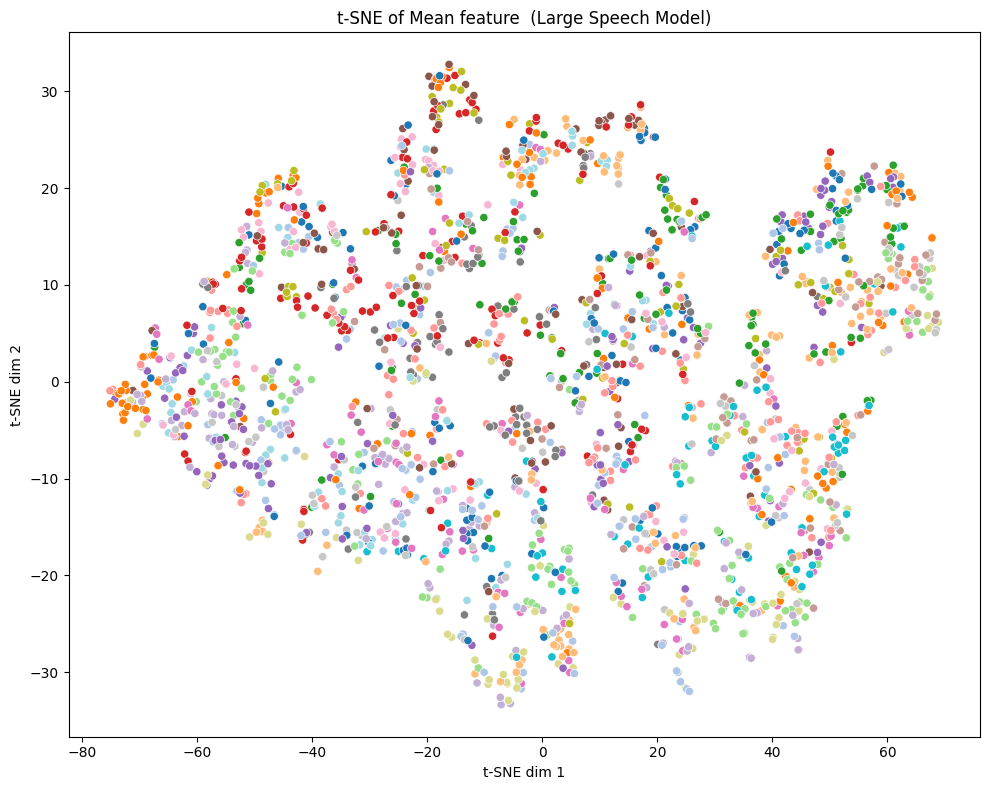

In [13]:
# Large Speech Model
mean_values = np.array([file_data['mean_features'] for file_data in file_data_list_ls])
gt_values = np.array([file_data['gt_category'] for file_data in file_data_list_ls])
#var_values = np.array([file_data['variance'] for file_data in file_data_list])

mean_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(mean_values)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=mean_tsne[:, 0], y=mean_tsne[:, 1], hue= gt_values, palette='tab20', legend=False)
plt.title("t-SNE of Mean feature  (Large Speech Model)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

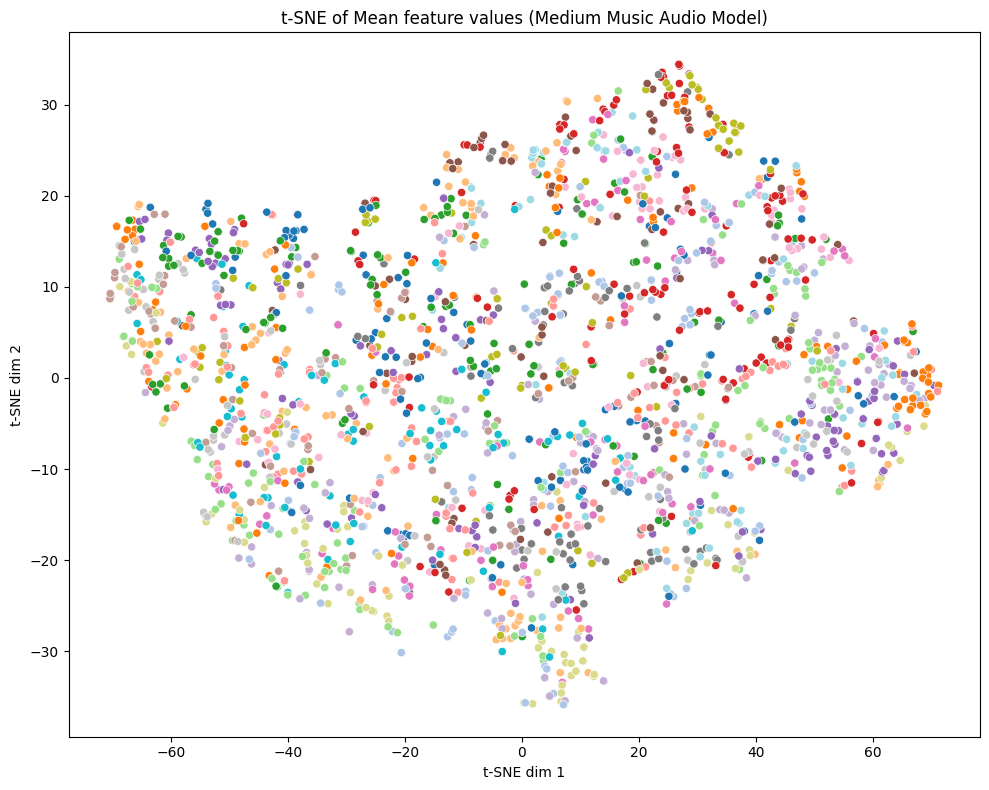

In [14]:
# Medium music model
mean_values = np.array([file_data['mean_features'] for file_data in file_data_list_mma])
gt_values = np.array([file_data['gt_category'] for file_data in file_data_list_mma])

mean_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(mean_values)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=mean_tsne[:, 0], y=mean_tsne[:, 1], hue= gt_values, palette='tab20', legend=False)
plt.title("t-SNE of Mean feature values (Medium Music Audio Model)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

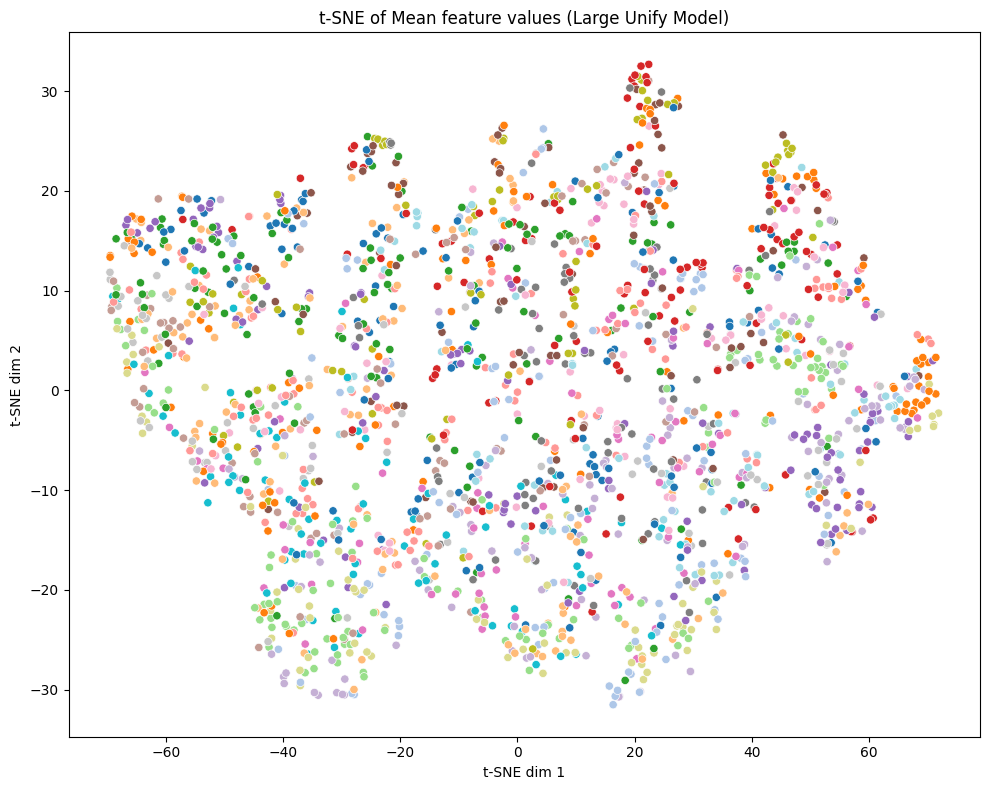

In [15]:
# Large unify model
mean_values = np.array([file_data['mean_features'] for file_data in file_data_list_lu])
gt_values = np.array([file_data['gt_category'] for file_data in file_data_list_lu])

mean_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(mean_values)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=mean_tsne[:, 0], y=mean_tsne[:, 1], hue= gt_values, palette='tab20', legend=False)
plt.title("t-SNE of Mean feature values (Large Unify Model)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

In [ ]:
# Test reconstruction audio
import torch
from IPython.display import Audio

wavtokenizer = wavtokenizer_large_speech # Changer le modele en conséquence
token_value = 470
num_tokens = 375 #375 ou 200 selon le modele pour un audio de 5 secondes
bandwidth_id = torch.tensor([0])

tokens = torch.full((1, 1, num_tokens), token_value, dtype=torch.long)
print(tokens.shape)

with torch.no_grad():
    features = wavtokenizer.codes_to_features(tokens)
print(features.shape)

with torch.no_grad():
    audio_out = wavtokenizer.decode(features, bandwidth_id=bandwidth_id)

audio_np = audio_out.squeeze().cpu().numpy()
Audio(audio_np, rate=24000)

torch.Size([1, 1, 375])
torch.Size([1, 512, 375])


In [ ]:
from collections import Counter

token_counts = Counter()

for file_data in file_data_list_mma:
    tokens = file_data['tokens']
    tokens_list = [item for sublist1 in tokens.tolist() for sublist2 in sublist1 for item in sublist2]

    token_counts.update(tokens_list)

sorted_token_counts = token_counts.most_common()

for token, count in sorted_token_counts:
    print(f"Token {token}: {count} occurrences")

#print(f'Token 470: {token_counts[470]} occurrences')

Token 1771: 73948 occurrences
Token 2485: 3849 occurrences
Token 155: 3324 occurrences
Token 3253: 3102 occurrences
Token 3381: 3089 occurrences
Token 1955: 2901 occurrences
Token 2941: 2790 occurrences
Token 2754: 2662 occurrences
Token 2638: 2528 occurrences
Token 824: 2388 occurrences
Token 2490: 2199 occurrences
Token 2711: 2192 occurrences
Token 1594: 2132 occurrences
Token 974: 2088 occurrences
Token 2634: 2087 occurrences
Token 862: 1960 occurrences
Token 3780: 1903 occurrences
Token 2588: 1894 occurrences
Token 1441: 1694 occurrences
Token 4051: 1690 occurrences
Token 3599: 1658 occurrences
Token 58: 1644 occurrences
Token 3297: 1640 occurrences
Token 1351: 1553 occurrences
Token 205: 1538 occurrences
Token 1888: 1520 occurrences
Token 2481: 1512 occurrences
Token 933: 1495 occurrences
Token 864: 1494 occurrences
Token 263: 1465 occurrences
Token 662: 1461 occurrences
Token 2080: 1453 occurrences
Token 1323: 1437 occurrences
Token 1209: 1430 occurrences
Token 3330: 1419 occurre